In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from skimage.segmentation import mark_boundaries
import itertools
import random
import time
import pickle

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from coral_mapper_functions import score_map
from coral_mapper import coral_map

## Import image

In [3]:
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point
from rasterio.mask import mask

C:\Users\tnguyen001\AppData\Roaming\Python\Python38\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-3-09e413e00eb4>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using P

In [102]:
#filenameraster='../../../Maupiti/Satellite Images/SPOT6/SPOT6_2018_HC_BRUT_NC_GEOSUD_MS_121/PROD_SPOT7_001/VOL_SPOT7_001_A/IMG_SPOT7_MS_001_A/IMG_SPOT7_MS_201806061951187_SEN_SPOT7_20200907_1020251m2uw7izmfzso_1_R1C1.TIF'
#filenameraster='../../../Maupiti/Satellite Images/POT6_2018.tif'
filenameraster='georeferenced_SPOT2018_1.tif'
#filenameraster='georeferenced_SPOT2018_2.tif'


adr=filenameraster[:-4]

src = rio.open(filenameraster)
X0, Y0, XF, YF=src.bounds
dx=(XF-X0)/src.width
dy=(YF-Y0)/src.height
x=np.arange(X0, XF, dx)
y=np.arange(Y0, YF, dy)

raster_array_original = src.read()

#img_final = raster_array_original[:,300:2100,500:2000]

In [19]:
src.crs

CRS.from_epsg(32731)

In [20]:
raster_array_original.shape

(4, 9039, 9652)

In [21]:
red = raster_array_original[0]
green = raster_array_original[1]
blue = raster_array_original[2]
nir = raster_array_original[3]

In [22]:
img_display = np.dstack((red/np.max(red),green/np.max(green),blue/np.max(blue)))

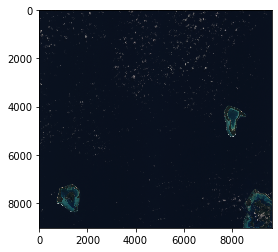

In [23]:
plt.imshow(img_display, interpolation='None')
plt.show()

In [37]:
#blue_train = blue[3300:-100,:1100]
#green_train = green[3300:-100,:1100]
#red_train = red[3300:-100,:1100]
#nir_train = nir[3300:-100,:1100]

blue_train = blue[7100:-600,600:1800]
green_train = green[7100:-600,600:1800]
red_train = red[7100:-600,600:1800]
nir_train = nir[7100:-600,600:1800]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


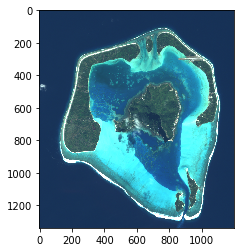

In [38]:
plt.imshow(np.dstack((red_train/1000, green_train/1000, blue_train/1000)), interpolation='None')
plt.show()

In [57]:
#blue_test = blue[100:1500,6900:7900]
#green_test = green[100:1500,6900:7900]
#red_test = red[100:1500,6900:7900]
#nir_test = nir[100:1500,6900:7900]

blue_test = blue[3900:5300,7600:8600]
green_test = green[3900:5300,7600:8600]
red_test = red[3900:5300,7600:8600]
nir_test = nir[3900:5300,7600:8600]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


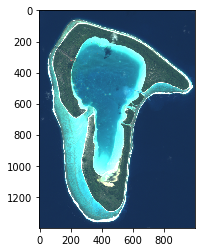

In [58]:
plt.imshow(np.dstack((red_test/1000, green_test/1000, blue_test/1000)), interpolation='None')
plt.show()

In [59]:
print(src.crs)
print(src.bounds)

EPSG:32731
BoundingBox(left=-2278375.1228429195, bottom=-8060816.114691701, right=-2200792.4760344187, top=-7981401.693945031)


## Convert the coordinates TIF image and create a new one with correct coordinates

In [12]:
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
from rasterio.crs import CRS

In [80]:
top_left_x = -2209524.5698032766
top_left_y = -8060830.611343749

top_right_x = -2283267.2591664856
top_right_y = -8049791.616445266

bottom_right_x = -2274387.636136111
bottom_right_y = -7985105.728133988

bottom_left_x = -2201601.3347223033
bottom_left_y = -7996086.7364242785

In [70]:
top_left_x = -2209524.5698032766
top_left_y = -8060830.611343749

bottom_left_x = -2283267.2591664856
bottom_left_y = -8049791.616445266

bottom_right_x = -2274387.636136111
bottom_right_y = -7985105.728133988

top_right_x = -2201601.3347223033
top_right_y = -7996086.7364242785

In [91]:
bottom_right_x = -2209524.5698032766
bottom_right_y = -8060830.611343749

bottom_left_x = -2283267.2591664856
bottom_left_y = -8049791.616445266

top_left_x = -2274387.636136111
top_left_y = -7985105.728133988

top_right_x = -2201601.3347223033
top_right_y = -7996086.7364242785

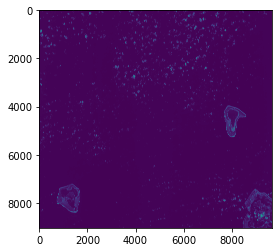

In [9]:
plt.imshow(raster_array_original[0])

In [93]:
# Image dimensions (replace with actual width and height of your image)
img_width = 9652
img_height = 9039

# Define Ground Control Points (GCPs)
gcps = [
    GroundControlPoint(0, 0, top_left_x, top_left_y),              # Top-left
    GroundControlPoint(img_width, 0, top_right_x, top_right_y),    # Top-right
    GroundControlPoint(img_width, img_height, bottom_right_x, bottom_right_y),  # Bottom-right
    GroundControlPoint(0, img_height, bottom_left_x, bottom_left_y)  # Bottom-left
]

# Calculate the affine transform
transform = from_gcps(gcps)

In [94]:
crs = CRS.from_epsg(32731)

# Update the metadata with the new transform and CRS
out_meta = src.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": img_height,
    "width": img_width,
    "transform": transform,
    "crs": crs
})

# Write the georeferenced image
with rio.open('georeferenced_SPOT2018_2.tif', 'w', **out_meta) as dst:
    dst.write(raster_array_original)

## Import zonation

In [61]:
from sklearn.preprocessing import LabelEncoder

In [33]:
import geopandas as gpd

# Define file paths
shapefile_path = '../../../Maupiti/Data/New_classification/Ma classification/maupiti_teo_32731.shp'
reprojected_shapefile_path = '../../../Maupiti/Data/New_classification/Ma classification/maupiti_teo_4326.shp'

# Read the shapefile
shapefile = gpd.read_file(shapefile_path)

# Reproject the shapefile to match the raster's CRS
shapefile_reprojected = shapefile.to_crs(src.crs)

# Save the reprojected shapefile
shapefile_reprojected.to_file(reprojected_shapefile_path)

In [62]:
types=gpd.read_file('../../../Maupiti/Data/New_classification/Ma classification/maupiti_teo_32731.shp')

In [63]:
types.crs

<Derived Projected CRS: EPSG:32731>
Name: WGS 84 / UTM zone 31S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, southern hemisphere between 80°S and equator, onshore and offshore.
- bounds: (0.0, -80.0, 6.0, 0.0)
Coordinate Operation:
- name: UTM zone 31S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
types

,Type,SubType,SubSubType,geometry
0,BackReefSlope,None,None,"POLYGON ((-2213616.189 -7999338.805, -2213613...."
1,BackReefSlope,None,None,"POLYGON ((-2215401.013 -8006112.221, -2215400...."
2,BackReefSlope,None,None,"POLYGON ((-2208999.631 -8002647.962, -2209008...."
3,BackReefSlope,None,None,"MULTIPOLYGON (((-2208743.167 -8004487.823, -22..."
4,BackReefSlope,None,None,"POLYGON ((-2215930.522 -8005460.888, -2215922...."
...,...,...,...,...
3201,Land,None,None,"POLYGON ((-2213751.107 -7999781.638, -2213820...."
3202,Ocean,None,None,"POLYGON ((-2208575.043 -8002233.077, -2209156...."
3203,Ocean,None,None,"POLYGON ((-2215675.910 -8001764.878, -2215264...."
3204,Ocean,None,None,"POLYGON ((-2214186.429 -8007556.503, -2216349...."


In [65]:
src.bounds

BoundingBox(left=-2278375.1228429195, bottom=-8060816.114691701, right=-2200792.4760344187, top=-7981401.693945031)

In [103]:
imageclip, _ = mask(src, types.geometry, invert=False)

In [104]:
label_encoder = LabelEncoder()
types['type_numeric'] = label_encoder.fit_transform(types['Type'])+1

# Retrieve the mapping of labels to numeric values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)+1))

# Print the mapping
print(label_mapping)

{'BackReefSlope': 1, 'InnerReef': 2, 'Lagoon': 3, 'Land': 4, 'Ocean': 5, 'OuterReefFlat': 6, 'PatchReef': 7, 'ReefCrest': 8, 'ReefFront': 9, 'ShallowLagoon': 10, 'ShoreReef': 11, 'Unspecified': 12}


In [105]:
# Read the shapefile
shapes = [(geom, value) for geom, value in zip(types['geometry'], types['type_numeric'])] 

# Rasterize the shapefile
rasterized = rio.features.rasterize(shapes,
                                out_shape=src.shape,
                                transform=src.transform,
                                fill=0)  # Fill value for pixels outside the shapes

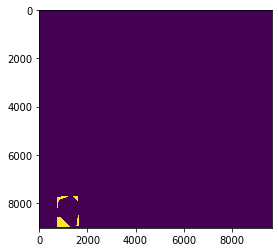

In [78]:
img_tests_masks = np.zeros(np.shape(rasterized))
img_tests_masks[rasterized==5] = 1

plt.imshow(img_tests_masks, interpolation='None')
plt.show()

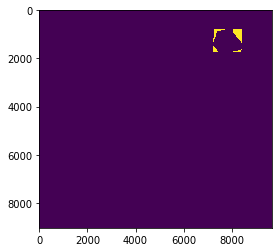

In [90]:
img_tests_masks = np.zeros(np.shape(rasterized))
img_tests_masks[rasterized==5] = 1

plt.imshow(img_tests_masks, interpolation='None')
plt.show()

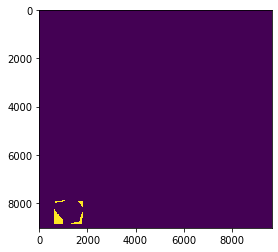

In [99]:
img_tests_masks = np.zeros(np.shape(rasterized))
img_tests_masks[rasterized==5] = 1

plt.imshow(img_tests_masks, interpolation='None')
plt.show()

## Trying to match training image with zonation

In [ ]:
blue_train = blue[7100:-600,600:1800]
green_train = green[7100:-600,600:1800]
red_train = red[7100:-600,600:1800]
nir_train = nir[7100:-600,600:1800]

In [128]:
9039-600

8439

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


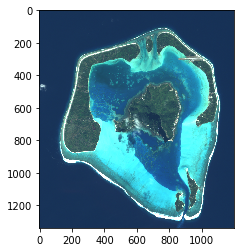

In [107]:
plt.imshow(np.dstack((red_train/1000, green_train/1000, blue_train/1000)), interpolation='None')
plt.show()

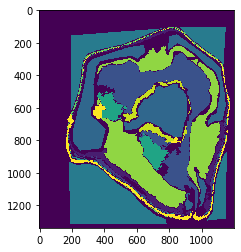

In [129]:
plt.imshow(np.fliplr(np.rot90(rasterized, k=3))[7100:8439,600:1800], interpolation='None')
plt.show()